# MNIST CNN model

**Target to achieve** : 99.4% accuracy on test dataset.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("./drive/My Drive/EVA/Session04")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importing Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from torchsummary import summary
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20,10)

## GPU for training

In [3]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()

try:
  print(f"Found GPU at : {device_name}")
except:
  print("GPU device not found.")

Found GPU at : /device:GPU:0


In [4]:
import torch

if torch.cuda.is_available():
  device = torch.device("cuda")
  use_cuda = True
  print(f"Number of GPU's available : {torch.cuda.device_count()}")
  print(f"GPU device name : {torch.cuda.get_device_name(0)}")
else:
  print("No GPU available, using CPU instead")
  device = torch.device("cpu")
  use_cuda = False

Number of GPU's available : 1
GPU device name : Tesla P4


## Downloading MNIST dataset

Things to keep in mind, 
- the dataset is provided by pytorch community.
- MNIST dataset contains: 
  - 60,000 training images
  - 10,000 test images 
  - Each image is of size (28x28x1).
- The values 0.1307 and 0.3081 used for the Normalize() transformation below are the global mean and standard deviation for MNIST dataset.

In [0]:
batch_size = 128
num_epochs = 20
kernel_size = 3
pool_size = 2

lr = 0.01
momentum = 0.9

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [0]:
mnist_trainset = datasets.MNIST(root="./data", train=True, download=True,
                                transform=transforms.Compose([
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.1307,), (0.3081,))
                    ]))

mnist_testset = datasets.MNIST(root="./data", train=False, download=True,
                               transform=transforms.Compose([
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.1307,), (0.3081,))
                    ]))

In [0]:
train_loader = torch.utils.data.DataLoader(mnist_trainset,
                                          batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(mnist_testset,
                                          batch_size=batch_size, shuffle=True, **kwargs)

## Visualization of images

In [0]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

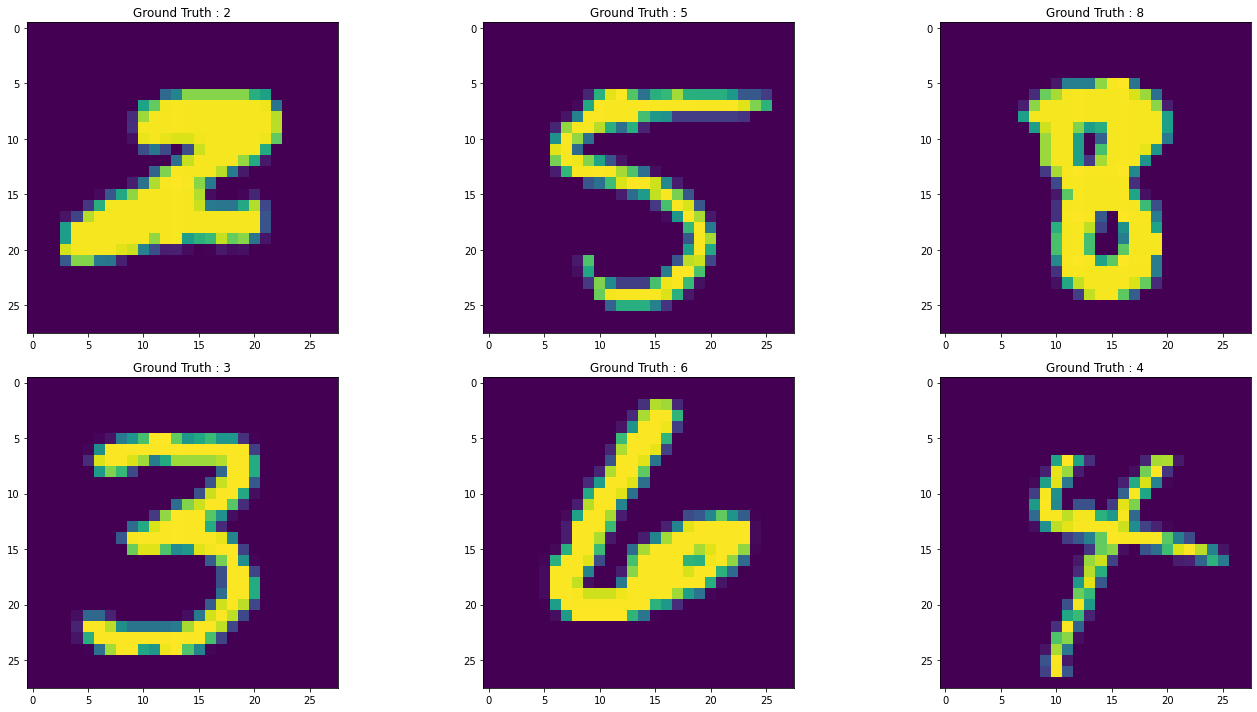

In [9]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], interpolation='none')
  plt.title(f"Ground Truth : {example_targets[i]}")

## Defining training and testing functions

In [0]:
from tqdm import tqdm

def train(model, device, train_loader, optimizer, epoch):
    running_loss = 0.0
    running_correct = 0

    model.train()
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        _, preds = torch.max(output.data, 1)
        loss.backward()
        optimizer.step()

        #calculate training running loss
        running_loss += loss.item()
        running_correct += (preds == target).sum().item()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')

    print("\n")
    print(f"Epoch {epoch} train loss: {running_loss/len(mnist_trainset):.3f} train acc: {running_correct/len(mnist_trainset):.3f}")

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

## Building the model

### Experiment 1

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)                    #(-1,28,28,3)>(-1,3,3,3,16)>(-1,28,28,16)
        self.batchnorm1 = nn.BatchNorm2d(16)                           #(-1,28,28,16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)                   #(-1,28,28,16)>(-1,3,3,16,32)>(-1,28,28,32)
        self.batchnorm2 = nn.BatchNorm2d(32)                           #(-1,28,28,32)
        self.pool1 = nn.MaxPool2d(2, 2)                                #(-1,14,14,32)
        self.drop1 = nn.Dropout2d(0.2)
        
        self.conv3 = nn.Conv2d(32, 16, 1)                              #(-1,14,14,32)>(-1,1,1,32,16)>(-1,14,14,16)
        self.conv4 = nn.Conv2d(16, 32, 3, padding=1)                   #(-1,14,14,16)>(-1,3,3,16,32)>(-1,14,14,32)
        self.batchnorm3 = nn.BatchNorm2d(32)                           #(-1,14,14,32)
        self.pool2 = nn.MaxPool2d(2, 2)                                #(-1,7,7,32)
        self.drop2 = nn.Dropout2d(0.2)


        self.conv6 = nn.Conv2d(32, 16, 3)                              #(-1,7,7,32)>(-1,3,3,32,16)>(-1,5,5,16)       
        self.conv8 = nn.AvgPool2d(5)

        self.fc1 = nn.Linear(16,10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.batchnorm1(x)
        x = F.relu(self.conv2(x))
        x = self.batchnorm2(x)
        x = self.pool1(x)
        x = self.drop1(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.batchnorm3(x)
        x = self.pool2(x)
        x = self.drop2(x)

        x = F.relu(self.conv6(x))
        x = self.conv8(x)
        x = x.view(-1, 16)
        x = self.fc1(x)
        return F.log_softmax(x)

In [88]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
       BatchNorm2d-2           [-1, 16, 28, 28]              32
            Conv2d-3           [-1, 32, 28, 28]           4,640
       BatchNorm2d-4           [-1, 32, 28, 28]              64
         MaxPool2d-5           [-1, 32, 14, 14]               0
         Dropout2d-6           [-1, 32, 14, 14]               0
            Conv2d-7           [-1, 16, 14, 14]             528
            Conv2d-8           [-1, 32, 14, 14]           4,640
       BatchNorm2d-9           [-1, 32, 14, 14]              64
        MaxPool2d-10             [-1, 32, 7, 7]               0
        Dropout2d-11             [-1, 32, 7, 7]               0
           Conv2d-12             [-1, 16, 5, 5]           4,624
        AvgPool2d-13             [-1, 16, 1, 1]               0
           Linear-14                   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [89]:
optimizer = optim.Adam(model.parameters(), lr=0.001)#, momentum=momentum)

for epoch in range(1, num_epochs+1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

loss=0.3514082729816437 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 42.55it/s]



Epoch 1 train loss: 0.005 train acc: 0.823



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1176, Accuracy: 9676/10000 (96.760%)



loss=0.1007683053612709 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 42.42it/s]



Epoch 2 train loss: 0.001 train acc: 0.959



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0711, Accuracy: 9787/10000 (97.870%)



loss=0.10431446880102158 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 41.71it/s]



Epoch 3 train loss: 0.001 train acc: 0.971



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0537, Accuracy: 9849/10000 (98.490%)



loss=0.08350273966789246 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 41.59it/s]



Epoch 4 train loss: 0.001 train acc: 0.976



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0449, Accuracy: 9866/10000 (98.660%)



loss=0.04174663498997688 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 41.59it/s]



Epoch 5 train loss: 0.001 train acc: 0.980



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0454, Accuracy: 9853/10000 (98.530%)



loss=0.025904187932610512 batch_id=468: 100%|██████████| 469/469 [00:10<00:00, 43.33it/s]




Epoch 6 train loss: 0.000 train acc: 0.981


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0387, Accuracy: 9878/10000 (98.780%)



loss=0.0669834315776825 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 42.25it/s]



Epoch 7 train loss: 0.000 train acc: 0.984



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0330, Accuracy: 9898/10000 (98.980%)



loss=0.027446210384368896 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 41.15it/s]



Epoch 8 train loss: 0.000 train acc: 0.984



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0347, Accuracy: 9896/10000 (98.960%)



loss=0.04692990705370903 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 41.94it/s]



Epoch 9 train loss: 0.000 train acc: 0.985



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0314, Accuracy: 9905/10000 (99.050%)



loss=0.06692922115325928 batch_id=468: 100%|██████████| 469/469 [00:10<00:00, 43.14it/s]



Epoch 10 train loss: 0.000 train acc: 0.987



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0315, Accuracy: 9892/10000 (98.920%)



loss=0.04230007901787758 batch_id=468: 100%|██████████| 469/469 [00:10<00:00, 43.07it/s]



Epoch 11 train loss: 0.000 train acc: 0.987



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0279, Accuracy: 9906/10000 (99.060%)



loss=0.025743434205651283 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 41.85it/s]



Epoch 12 train loss: 0.000 train acc: 0.988



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0310, Accuracy: 9909/10000 (99.090%)



loss=0.029104769229888916 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 41.29it/s]



Epoch 13 train loss: 0.000 train acc: 0.988



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0310, Accuracy: 9899/10000 (98.990%)



loss=0.0932946428656578 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 42.33it/s]



Epoch 14 train loss: 0.000 train acc: 0.989



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0349, Accuracy: 9898/10000 (98.980%)



loss=0.03370952233672142 batch_id=468: 100%|██████████| 469/469 [00:10<00:00, 42.82it/s]



Epoch 15 train loss: 0.000 train acc: 0.989



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0292, Accuracy: 9912/10000 (99.120%)



loss=0.05643368884921074 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 41.61it/s]



Epoch 16 train loss: 0.000 train acc: 0.989



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Accuracy: 9903/10000 (99.030%)



loss=0.019223518669605255 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 42.11it/s]



Epoch 17 train loss: 0.000 train acc: 0.990



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9920/10000 (99.200%)



loss=0.09014540910720825 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 42.49it/s]



Epoch 18 train loss: 0.000 train acc: 0.990



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0322, Accuracy: 9901/10000 (99.010%)



loss=0.012379363179206848 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 42.29it/s]



Epoch 19 train loss: 0.000 train acc: 0.990



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9925/10000 (99.250%)



loss=0.012927338480949402 batch_id=468: 100%|██████████| 469/469 [00:10<00:00, 43.50it/s]



Epoch 20 train loss: 0.000 train acc: 0.992



Test set: Average loss: 0.0230, Accuracy: 9923/10000 (99.230%)



### Experiment 2

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)                    #(-1,28,28,3)>(-1,3,3,3,32)>(-1,28,28,32)
        self.batchnorm1 = nn.BatchNorm2d(32)                           #(-1,28,28,32)
        self.conv2 = nn.Conv2d(32, 16, 3, padding=1)                   #(-1,28,28,32)>(-1,3,3,32,16)>(-1,28,28,16)
        self.batchnorm2 = nn.BatchNorm2d(16)                           #(-1,28,28,16)
        
        self.pool1 = nn.MaxPool2d(2, 2)                                #(-1,14,14,16)
        self.drop1 = nn.Dropout2d(0.2)
        
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)                   #(-1,14,14,16)>(-1,3,3,16,32)>(-1,14,14,32)
        self.batchnorm3 = nn.BatchNorm2d(32)                           #(-1,14,14,32)
        self.conv4 = nn.Conv2d(32, 16, 3, padding=1)                   #(-1,14,14,32)>(-1,3,3,32,16)>(-1,14,14,16)
        self.batchnorm4 = nn.BatchNorm2d(16)                           #(-1,14,14,16)
        
        self.pool2 = nn.MaxPool2d(2, 2)                                #(-1,7,7,16)
        self.drop2 = nn.Dropout2d(0.2)

        self.conv5 = nn.Conv2d(16, 16, 3)                              #(-1,7,7,16)>(-1,3,3,16,16)>(-1,5,5,16)        
        self.avgpool = nn.AvgPool2d(5)

        self.fc1 = nn.Linear(16,10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.batchnorm1(x)
        x = F.relu(self.conv2(x))
        x = self.batchnorm2(x)
        
        x = self.pool1(x)
        x = self.drop1(x)

        x = F.relu(self.conv3(x))
        x = self.batchnorm3(x)
        x = F.relu(self.conv4(x))
        x = self.batchnorm4(x)
        
        x = self.pool2(x)
        x = self.drop2(x)

        x = F.relu(self.conv5(x))
        x = self.avgpool(x)
        x = x.view(-1, 16)
        x = self.fc1(x)
        return F.log_softmax(x)

In [91]:
model1 = Net().to(device)
summary(model1, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
            Conv2d-3           [-1, 16, 28, 28]           4,624
       BatchNorm2d-4           [-1, 16, 28, 28]              32
         MaxPool2d-5           [-1, 16, 14, 14]               0
         Dropout2d-6           [-1, 16, 14, 14]               0
            Conv2d-7           [-1, 32, 14, 14]           4,640
       BatchNorm2d-8           [-1, 32, 14, 14]              64
            Conv2d-9           [-1, 16, 14, 14]           4,624
      BatchNorm2d-10           [-1, 16, 14, 14]              32
        MaxPool2d-11             [-1, 16, 7, 7]               0
        Dropout2d-12             [-1, 16, 7, 7]               0
           Conv2d-13             [-1, 16, 5, 5]           2,320
        AvgPool2d-14             [-1, 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [92]:
optimizer = optim.Adam(model1.parameters(), lr=0.001)#, momentum=momentum)

for epoch in range(1, num_epochs+1):
    train(model1, device, train_loader, optimizer, epoch)
    test(model1, device, test_loader)

loss=0.2471468597650528 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 40.93it/s]



Epoch 1 train loss: 0.005 train acc: 0.797



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1046, Accuracy: 9721/10000 (97.210%)



loss=0.06796997040510178 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 42.01it/s]



Epoch 2 train loss: 0.001 train acc: 0.959



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0570, Accuracy: 9824/10000 (98.240%)



loss=0.06555097550153732 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 41.33it/s]



Epoch 3 train loss: 0.001 train acc: 0.971



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0481, Accuracy: 9857/10000 (98.570%)



loss=0.13390624523162842 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 41.55it/s]



Epoch 4 train loss: 0.001 train acc: 0.976



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0550, Accuracy: 9828/10000 (98.280%)



loss=0.1284576803445816 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 40.80it/s]



Epoch 5 train loss: 0.001 train acc: 0.980



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0368, Accuracy: 9889/10000 (98.890%)



loss=0.046048685908317566 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 41.43it/s]



Epoch 6 train loss: 0.000 train acc: 0.981



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0341, Accuracy: 9892/10000 (98.920%)



loss=0.011576011776924133 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 42.60it/s]



Epoch 7 train loss: 0.000 train acc: 0.983



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0341, Accuracy: 9893/10000 (98.930%)



loss=0.07269971817731857 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 41.69it/s]



Epoch 8 train loss: 0.000 train acc: 0.983



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0306, Accuracy: 9895/10000 (98.950%)



loss=0.02010648511350155 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 41.94it/s]



Epoch 9 train loss: 0.000 train acc: 0.985



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0346, Accuracy: 9893/10000 (98.930%)



loss=0.013141174800693989 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 42.12it/s]



Epoch 10 train loss: 0.000 train acc: 0.986



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0295, Accuracy: 9902/10000 (99.020%)



loss=0.030623629689216614 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 42.12it/s]



Epoch 11 train loss: 0.000 train acc: 0.987



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0288, Accuracy: 9908/10000 (99.080%)



loss=0.00675491476431489 batch_id=468: 100%|██████████| 469/469 [00:10<00:00, 43.13it/s]



Epoch 12 train loss: 0.000 train acc: 0.987



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Accuracy: 9906/10000 (99.060%)



loss=0.014579127542674541 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 41.98it/s]



Epoch 13 train loss: 0.000 train acc: 0.987



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0266, Accuracy: 9909/10000 (99.090%)



loss=0.011008580215275288 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 40.73it/s]



Epoch 14 train loss: 0.000 train acc: 0.988



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9924/10000 (99.240%)



loss=0.02701221965253353 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 41.67it/s]



Epoch 15 train loss: 0.000 train acc: 0.989



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9921/10000 (99.210%)



loss=0.01278597116470337 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 42.50it/s]



Epoch 16 train loss: 0.000 train acc: 0.989



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9927/10000 (99.270%)



loss=0.05060496926307678 batch_id=468: 100%|██████████| 469/469 [00:10<00:00, 43.14it/s]



Epoch 17 train loss: 0.000 train acc: 0.989



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0272, Accuracy: 9921/10000 (99.210%)



loss=0.06127500161528587 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 41.27it/s]



Epoch 18 train loss: 0.000 train acc: 0.989



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9921/10000 (99.210%)



loss=0.056384410709142685 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 39.65it/s]



Epoch 19 train loss: 0.000 train acc: 0.990



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Accuracy: 9916/10000 (99.160%)



loss=0.04166630655527115 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 40.23it/s]



Epoch 20 train loss: 0.000 train acc: 0.990



Test set: Average loss: 0.0264, Accuracy: 9910/10000 (99.100%)



## Experiment 3

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.drop = nn.Dropout2d(0.1)

        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)                    #(-1,28,28,3)>(-1,3,3,3,16)>(-1,28,28,16)
        self.batchnorm1 = nn.BatchNorm2d(16)                           #(-1,28,28,16)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1)                   #(-1,28,28,16)>(-1,3,3,16,16)>(-1,28,28,16)
        self.batchnorm2 = nn.BatchNorm2d(16)                           #(-1,28,28,16)
        
        self.pool1 = nn.MaxPool2d(2, 2)                                #(-1,14,14,16)
        
        self.conv3 = nn.Conv2d(16, 16, 3, padding=1)                   #(-1,14,14,16)>(-1,3,3,16,16)>(-1,14,14,16)
        self.batchnorm3 = nn.BatchNorm2d(16)                           #(-1,14,14,16)
        self.conv4 = nn.Conv2d(16, 16, 3, padding=1)                   #(-1,14,14,16)>(-1,3,3,32,16)>(-1,14,14,16)
        self.batchnorm4 = nn.BatchNorm2d(16)                           #(-1,14,14,16)
        
        self.pool2 = nn.MaxPool2d(2, 2)                                #(-1,7,7,16)
        
        self.conv5 = nn.Conv2d(16, 32, 3)                              #(-1,7,7,32)>(-1,3,3,16,32)>(-1,5,5,32)        
        self.avgpool = nn.AvgPool2d(5)

        self.fc1 = nn.Linear(32,10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.batchnorm1(x)
        x = self.drop(x)
        x = F.relu(self.conv2(x))
        x = self.batchnorm2(x)
        x = self.drop(x)
        
        x = self.pool1(x)
        
        x = F.relu(self.conv3(x))
        x = self.batchnorm3(x)
        x = self.drop(x)
        x = F.relu(self.conv4(x))
        x = self.batchnorm4(x)
        x = self.drop(x)
        
        x = self.pool2(x)
        
        x = F.relu(self.conv5(x))
        x = self.avgpool(x)
        x = x.view(-1, 32)
        x = self.fc1(x)
        return F.log_softmax(x)

In [94]:
model2 = Net().to(device)
summary(model2, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
       BatchNorm2d-2           [-1, 16, 28, 28]              32
         Dropout2d-3           [-1, 16, 28, 28]               0
            Conv2d-4           [-1, 16, 28, 28]           2,320
       BatchNorm2d-5           [-1, 16, 28, 28]              32
         Dropout2d-6           [-1, 16, 28, 28]               0
         MaxPool2d-7           [-1, 16, 14, 14]               0
            Conv2d-8           [-1, 16, 14, 14]           2,320
       BatchNorm2d-9           [-1, 16, 14, 14]              32
        Dropout2d-10           [-1, 16, 14, 14]               0
           Conv2d-11           [-1, 16, 14, 14]           2,320
      BatchNorm2d-12           [-1, 16, 14, 14]              32
        Dropout2d-13           [-1, 16, 14, 14]               0
        MaxPool2d-14             [-1, 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [95]:
optimizer = optim.Adam(model2.parameters(), lr=0.001)#, momentum=momentum)

for epoch in range(1, num_epochs+1):
    train(model2, device, train_loader, optimizer, epoch)
    test(model2, device, test_loader)

loss=0.17762015759944916 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 40.60it/s]



Epoch 1 train loss: 0.005 train acc: 0.822



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1190, Accuracy: 9664/10000 (96.640%)



loss=0.11383804678916931 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 41.73it/s]



Epoch 2 train loss: 0.001 train acc: 0.957



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0633, Accuracy: 9805/10000 (98.050%)



loss=0.09433180838823318 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 41.43it/s]



Epoch 3 train loss: 0.001 train acc: 0.969



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0542, Accuracy: 9825/10000 (98.250%)



loss=0.08805123716592789 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 41.32it/s]



Epoch 4 train loss: 0.001 train acc: 0.976



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0420, Accuracy: 9879/10000 (98.790%)



loss=0.039287909865379333 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 41.63it/s]



Epoch 5 train loss: 0.001 train acc: 0.978



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0366, Accuracy: 9882/10000 (98.820%)



loss=0.019734302535653114 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 42.61it/s]



Epoch 6 train loss: 0.000 train acc: 0.981



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0320, Accuracy: 9895/10000 (98.950%)



loss=0.030187880620360374 batch_id=468: 100%|██████████| 469/469 [00:10<00:00, 43.20it/s]



Epoch 7 train loss: 0.000 train acc: 0.982



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0304, Accuracy: 9904/10000 (99.040%)



loss=0.07125528901815414 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 41.14it/s]



Epoch 8 train loss: 0.000 train acc: 0.984



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9902/10000 (99.020%)



loss=0.041736867278814316 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 42.35it/s]



Epoch 9 train loss: 0.000 train acc: 0.985



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0274, Accuracy: 9916/10000 (99.160%)



loss=0.012403408996760845 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 41.72it/s]



Epoch 10 train loss: 0.000 train acc: 0.986



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9921/10000 (99.210%)



loss=0.042330119758844376 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 40.66it/s]



Epoch 11 train loss: 0.000 train acc: 0.986



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9924/10000 (99.240%)



loss=0.11958160996437073 batch_id=468: 100%|██████████| 469/469 [00:10<00:00, 43.10it/s]



Epoch 12 train loss: 0.000 train acc: 0.986



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9920/10000 (99.200%)



loss=0.13536112010478973 batch_id=468: 100%|██████████| 469/469 [00:10<00:00, 43.27it/s]



Epoch 13 train loss: 0.000 train acc: 0.987



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 9915/10000 (99.150%)



loss=0.00650086859241128 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 42.30it/s]



Epoch 14 train loss: 0.000 train acc: 0.988



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9930/10000 (99.300%)



loss=0.0073151797987520695 batch_id=468: 100%|██████████| 469/469 [00:10<00:00, 43.45it/s]



Epoch 15 train loss: 0.000 train acc: 0.988



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9934/10000 (99.340%)



loss=0.06478995829820633 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 41.30it/s]



Epoch 16 train loss: 0.000 train acc: 0.989



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9910/10000 (99.100%)



loss=0.024970777332782745 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 41.29it/s]



Epoch 17 train loss: 0.000 train acc: 0.989



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9926/10000 (99.260%)



loss=0.03481917083263397 batch_id=468: 100%|██████████| 469/469 [00:10<00:00, 43.06it/s]



Epoch 18 train loss: 0.000 train acc: 0.989



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9932/10000 (99.320%)



loss=0.0027312561869621277 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 41.21it/s]



Epoch 19 train loss: 0.000 train acc: 0.990



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9929/10000 (99.290%)



loss=0.0090356869623065 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 42.57it/s]



Epoch 20 train loss: 0.000 train acc: 0.990



Test set: Average loss: 0.0234, Accuracy: 9927/10000 (99.270%)



## Experiment 4

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.drop = nn.Dropout2d(0.1)

        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)                    #(-1,28,28,3)>(-1,3,3,3,16)>(-1,28,28,16)
        self.batchnorm1 = nn.BatchNorm2d(16)                           #(-1,28,28,16)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1)                   #(-1,28,28,16)>(-1,3,3,10,16)>(-1,28,28,16)
        self.batchnorm2 = nn.BatchNorm2d(16)                           #(-1,28,28,16)
        
        self.pool1 = nn.MaxPool2d(2, 2)                                #(-1,14,14,16)
        
        self.conv3 = nn.Conv2d(16, 16, 3, padding=1)                   #(-1,14,14,16)>(-1,3,3,16,16)>(-1,14,14,16)
        self.batchnorm3 = nn.BatchNorm2d(16)                           #(-1,14,14,16)
        self.conv4 = nn.Conv2d(16, 16, 3, padding=1)                   #(-1,14,14,16)>(-1,3,3,16,16)>(-1,14,14,16)
        self.batchnorm4 = nn.BatchNorm2d(16)                           #(-1,14,14,16)
        
        self.pool2 = nn.MaxPool2d(2, 2)                                #(-1,7,7,16)
        
        self.conv5 = nn.Conv2d(16, 16, 3)                              #(-1,7,7,16)>(-1,3,3,16,16)>(-1,5,5,16)        
        self.avgpool = nn.AvgPool2d(5)

        self.fc1 = nn.Linear(16,10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.batchnorm1(x)
        x = self.drop(x)
        x = F.relu(self.conv2(x))
        x = self.batchnorm2(x)   
        x = self.drop(x)     
        
        x = self.pool1(x)
        
        x = F.relu(self.conv3(x))
        x = self.batchnorm3(x)
        x = self.drop(x)
        x = F.relu(self.conv4(x))
        x = self.batchnorm4(x)
        x = self.drop(x)
        
        x = self.pool2(x)
        
        x = F.relu(self.conv5(x))
        x = self.avgpool(x)
        x = x.view(-1, 16)
        x = self.fc1(x)
        return F.log_softmax(x)

In [97]:
model3 = Net().to(device)
summary(model3, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
       BatchNorm2d-2           [-1, 16, 28, 28]              32
         Dropout2d-3           [-1, 16, 28, 28]               0
            Conv2d-4           [-1, 16, 28, 28]           2,320
       BatchNorm2d-5           [-1, 16, 28, 28]              32
         Dropout2d-6           [-1, 16, 28, 28]               0
         MaxPool2d-7           [-1, 16, 14, 14]               0
            Conv2d-8           [-1, 16, 14, 14]           2,320
       BatchNorm2d-9           [-1, 16, 14, 14]              32
        Dropout2d-10           [-1, 16, 14, 14]               0
           Conv2d-11           [-1, 16, 14, 14]           2,320
      BatchNorm2d-12           [-1, 16, 14, 14]              32
        Dropout2d-13           [-1, 16, 14, 14]               0
        MaxPool2d-14             [-1, 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [98]:
optimizer = optim.SGD(model3.parameters(), lr=lr, momentum=momentum)

for epoch in range(1, num_epochs+1):
    train(model3, device, train_loader, optimizer, epoch)
    test(model3, device, test_loader)

loss=0.19698797166347504 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 42.57it/s]



Epoch 1 train loss: 0.005 train acc: 0.772



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1345, Accuracy: 9613/10000 (96.130%)



loss=0.09206434339284897 batch_id=468: 100%|██████████| 469/469 [00:10<00:00, 43.12it/s]



Epoch 2 train loss: 0.001 train acc: 0.952



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0667, Accuracy: 9796/10000 (97.960%)



loss=0.05245774984359741 batch_id=468: 100%|██████████| 469/469 [00:10<00:00, 42.87it/s]



Epoch 3 train loss: 0.001 train acc: 0.966



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0564, Accuracy: 9823/10000 (98.230%)



loss=0.08598563820123672 batch_id=468: 100%|██████████| 469/469 [00:10<00:00, 42.97it/s]



Epoch 4 train loss: 0.001 train acc: 0.972



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0506, Accuracy: 9840/10000 (98.400%)



loss=0.051839981228113174 batch_id=468: 100%|██████████| 469/469 [00:10<00:00, 43.74it/s]



Epoch 5 train loss: 0.001 train acc: 0.975



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0413, Accuracy: 9870/10000 (98.700%)



loss=0.1646825522184372 batch_id=468: 100%|██████████| 469/469 [00:10<00:00, 43.37it/s]



Epoch 6 train loss: 0.001 train acc: 0.977



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0402, Accuracy: 9865/10000 (98.650%)



loss=0.12344548106193542 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 42.54it/s]



Epoch 7 train loss: 0.001 train acc: 0.979



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0342, Accuracy: 9884/10000 (98.840%)



loss=0.04680343344807625 batch_id=468: 100%|██████████| 469/469 [00:10<00:00, 43.65it/s]



Epoch 8 train loss: 0.000 train acc: 0.980



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0347, Accuracy: 9893/10000 (98.930%)



loss=0.11142698675394058 batch_id=468: 100%|██████████| 469/469 [00:10<00:00, 43.67it/s]



Epoch 9 train loss: 0.000 train acc: 0.982



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0326, Accuracy: 9895/10000 (98.950%)



loss=0.05201985314488411 batch_id=468: 100%|██████████| 469/469 [00:10<00:00, 44.23it/s]



Epoch 10 train loss: 0.000 train acc: 0.982



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0332, Accuracy: 9896/10000 (98.960%)



loss=0.04166128858923912 batch_id=468: 100%|██████████| 469/469 [00:10<00:00, 44.17it/s]



Epoch 11 train loss: 0.000 train acc: 0.983



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0361, Accuracy: 9892/10000 (98.920%)



loss=0.09455183148384094 batch_id=468: 100%|██████████| 469/469 [00:10<00:00, 43.17it/s]



Epoch 12 train loss: 0.000 train acc: 0.984



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0306, Accuracy: 9912/10000 (99.120%)



loss=0.06874579936265945 batch_id=468: 100%|██████████| 469/469 [00:10<00:00, 43.98it/s]



Epoch 13 train loss: 0.000 train acc: 0.985



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0300, Accuracy: 9909/10000 (99.090%)



loss=0.030746325850486755 batch_id=468: 100%|██████████| 469/469 [00:10<00:00, 44.45it/s]



Epoch 14 train loss: 0.000 train acc: 0.985



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0302, Accuracy: 9908/10000 (99.080%)



loss=0.024722561240196228 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 42.26it/s]



Epoch 15 train loss: 0.000 train acc: 0.986



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0311, Accuracy: 9899/10000 (98.990%)



loss=0.008989989757537842 batch_id=468: 100%|██████████| 469/469 [00:10<00:00, 44.39it/s]



Epoch 16 train loss: 0.000 train acc: 0.986



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0324, Accuracy: 9900/10000 (99.000%)



loss=0.05281609669327736 batch_id=468: 100%|██████████| 469/469 [00:10<00:00, 43.32it/s]



Epoch 17 train loss: 0.000 train acc: 0.987



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 9908/10000 (99.080%)



loss=0.01986185647547245 batch_id=468: 100%|██████████| 469/469 [00:10<00:00, 43.37it/s]



Epoch 18 train loss: 0.000 train acc: 0.987



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0302, Accuracy: 9901/10000 (99.010%)



loss=0.0551479272544384 batch_id=468: 100%|██████████| 469/469 [00:10<00:00, 44.35it/s]



Epoch 19 train loss: 0.000 train acc: 0.987



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0310, Accuracy: 9908/10000 (99.080%)



loss=0.05109352245926857 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 41.51it/s]



Epoch 20 train loss: 0.000 train acc: 0.987



Test set: Average loss: 0.0299, Accuracy: 9908/10000 (99.080%)



## Experiment 5

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.drop = nn.Dropout2d(0.1)

        self.conv1 = nn.Conv2d(1, 16, 3, padding=1, bias=False)                    #(-1,28,28,3)>(-1,3,3,3,16)>(-1,28,28,16)
        self.batchnorm1 = nn.BatchNorm2d(16)                           #(-1,28,28,16)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1, bias=False)                   #(-1,28,28,16)>(-1,3,3,16,16)>(-1,28,28,16)
        self.batchnorm2 = nn.BatchNorm2d(16)                           #(-1,28,28,16)
        
        self.pool1 = nn.MaxPool2d(2, 2)                                #(-1,14,14,16)
        
        self.conv3 = nn.Conv2d(16, 16, 3, padding=1, bias=False)                   #(-1,14,14,16)>(-1,3,3,16,16)>(-1,14,14,16)
        self.batchnorm3 = nn.BatchNorm2d(16)                           #(-1,14,14,16)
        self.conv4 = nn.Conv2d(16, 16, 3, padding=1, bias=False)                   #(-1,14,14,16)>(-1,3,3,16,16)>(-1,14,14,16)
        self.batchnorm4 = nn.BatchNorm2d(16)                           #(-1,14,14,16)
        
        self.pool2 = nn.MaxPool2d(2, 2)                                #(-1,7,7,16)
        
        self.conv5 = nn.Conv2d(16, 32, 3)                              #(-1,7,7,16)>(-1,3,3,16,32)>(-1,5,5,32)
        self.batchnorm5 = nn.BatchNorm2d(32)        
        self.conv6 = nn.Conv2d(32, 16, 3)                              #(-1,5,5,32)>(-1,3,3,32,16)>(-1,3,3,16)
        self.batchnorm6 = nn.BatchNorm2d(16)
        self.conv7 = nn.Conv2d(16, 10, 3)                              #(-1,3,3,16)>(-1,3,3,16,10)>(-1,1,1,10)
        #self.avgpool = nn.AvgPool2d(5)

        #self.fc1 = nn.Linear(32,16)
        #self.fc2 = nn.Linear(16,10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.drop(x)
        x = self.batchnorm1(x)
        x = F.relu(self.conv2(x))
        x = self.drop(x)
        x = self.batchnorm2(x)
        
        x = self.pool1(x)
        
        x = F.relu(self.conv3(x))
        x = self.drop(x)
        x = self.batchnorm3(x)
        x = F.relu(self.conv4(x))
        x = self.drop(x)
        x = self.batchnorm4(x)
        
        x = self.pool2(x)
        
        x = F.relu(self.conv5(x))
        x = self.drop(x)
        x = self.batchnorm5(x)

        x = F.relu(self.conv6(x))
        x = self.drop(x)
        x = self.batchnorm6(x)
        
        x = self.conv7(x)
        #x = self.avgpool(x)
        #x = x.view(-1, 32)
        #x = self.fc1(x)
        #x = self.fc2(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [113]:
model4 = Net().to(device)
summary(model4, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             144
         Dropout2d-2           [-1, 16, 28, 28]               0
       BatchNorm2d-3           [-1, 16, 28, 28]              32
            Conv2d-4           [-1, 16, 28, 28]           2,304
         Dropout2d-5           [-1, 16, 28, 28]               0
       BatchNorm2d-6           [-1, 16, 28, 28]              32
         MaxPool2d-7           [-1, 16, 14, 14]               0
            Conv2d-8           [-1, 16, 14, 14]           2,304
         Dropout2d-9           [-1, 16, 14, 14]               0
      BatchNorm2d-10           [-1, 16, 14, 14]              32
           Conv2d-11           [-1, 16, 14, 14]           2,304
        Dropout2d-12           [-1, 16, 14, 14]               0
      BatchNorm2d-13           [-1, 16, 14, 14]              32
        MaxPool2d-14             [-1, 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [114]:
optimizer = optim.SGD(model4.parameters(), lr=lr, momentum=momentum)

for epoch in range(1, num_epochs+1):
    train(model4, device, train_loader, optimizer, epoch)
    test(model4, device, test_loader)

loss=0.13444219529628754 batch_id=468: 100%|██████████| 469/469 [00:12<00:00, 38.26it/s]



Epoch 1 train loss: 0.002 train acc: 0.926



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0522, Accuracy: 9829/10000 (98.290%)



loss=0.047479402273893356 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 39.79it/s]



Epoch 2 train loss: 0.001 train acc: 0.975



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0374, Accuracy: 9878/10000 (98.780%)



loss=0.022533103823661804 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 41.09it/s]



Epoch 3 train loss: 0.000 train acc: 0.980



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0330, Accuracy: 9900/10000 (99.000%)



loss=0.03890940174460411 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 41.74it/s]



Epoch 4 train loss: 0.000 train acc: 0.983



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0309, Accuracy: 9896/10000 (98.960%)



loss=0.08194504678249359 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 42.04it/s]



Epoch 5 train loss: 0.000 train acc: 0.984



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9915/10000 (99.150%)



loss=0.06837218999862671 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 40.54it/s]



Epoch 6 train loss: 0.000 train acc: 0.985



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9911/10000 (99.110%)



loss=0.02874426543712616 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 40.42it/s]



Epoch 7 train loss: 0.000 train acc: 0.987



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9917/10000 (99.170%)



loss=0.026206200942397118 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 41.68it/s]



Epoch 8 train loss: 0.000 train acc: 0.988



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9920/10000 (99.200%)



loss=0.0692075565457344 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 42.31it/s]



Epoch 9 train loss: 0.000 train acc: 0.988



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9919/10000 (99.190%)



loss=0.014157469384372234 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 41.48it/s]



Epoch 10 train loss: 0.000 train acc: 0.989



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9920/10000 (99.200%)



loss=0.008920957334339619 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 42.29it/s]



Epoch 11 train loss: 0.000 train acc: 0.989



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9926/10000 (99.260%)



loss=0.06225169077515602 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 41.33it/s]



Epoch 12 train loss: 0.000 train acc: 0.990



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9919/10000 (99.190%)



loss=0.003366231918334961 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 40.25it/s]



Epoch 13 train loss: 0.000 train acc: 0.991



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9926/10000 (99.260%)



loss=0.10454162210226059 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 41.77it/s]



Epoch 14 train loss: 0.000 train acc: 0.991



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9920/10000 (99.200%)



loss=0.009745706804096699 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 41.24it/s]



Epoch 15 train loss: 0.000 train acc: 0.991



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9936/10000 (99.360%)



loss=0.005046913865953684 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 40.86it/s]



Epoch 16 train loss: 0.000 train acc: 0.992



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9930/10000 (99.300%)



loss=0.04608719050884247 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 42.02it/s]



Epoch 17 train loss: 0.000 train acc: 0.991



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Accuracy: 9920/10000 (99.200%)



loss=0.06489522010087967 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 41.24it/s]



Epoch 18 train loss: 0.000 train acc: 0.992



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9928/10000 (99.280%)



loss=0.013460914604365826 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 40.17it/s]



Epoch 19 train loss: 0.000 train acc: 0.992



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9921/10000 (99.210%)



loss=0.010467450134456158 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 40.71it/s]



Epoch 20 train loss: 0.000 train acc: 0.992



Test set: Average loss: 0.0215, Accuracy: 9926/10000 (99.260%)



## Experiment 6 : Successful

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.drop = nn.Dropout2d(0.1)

        self.conv1 = nn.Conv2d(1, 16, 3, padding=1, bias=False)                    #(-1,28,28,3)>(-1,3,3,3,16)>(-1,28,28,16)
        self.batchnorm1 = nn.BatchNorm2d(16)                           #(-1,28,28,16)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1, bias=False)                   #(-1,28,28,16)>(-1,3,3,16,16)>(-1,28,28,16)
        self.batchnorm2 = nn.BatchNorm2d(16)                           #(-1,28,28,16)
        
        self.pool1 = nn.MaxPool2d(2, 2)                                #(-1,14,14,16)
        
        self.conv3 = nn.Conv2d(16, 16, 3, padding=1, bias=False)                   #(-1,14,14,16)>(-1,3,3,16,16)>(-1,14,14,16)
        self.batchnorm3 = nn.BatchNorm2d(16)                           #(-1,14,14,16)
        self.conv4 = nn.Conv2d(16, 16, 3, padding=1, bias=False)                   #(-1,14,14,16)>(-1,3,3,16,16)>(-1,14,14,16)
        self.batchnorm4 = nn.BatchNorm2d(16)                           #(-1,14,14,16)
        
        self.pool2 = nn.MaxPool2d(2, 2)                                #(-1,7,7,16)
        
        self.conv5 = nn.Conv2d(16, 32, 3, padding=1, bias=False)         #(-1,7,7,16)>(-1,3,3,16,32)>(-1,7,7,32)
        self.batchnorm5 = nn.BatchNorm2d(32)        
        self.conv6 = nn.Conv2d(32, 16, 3, padding=1, bias=False)         #(-1,7,7,32)>(-1,3,3,32,16)>(-1,7,7,16)
        self.batchnorm6 = nn.BatchNorm2d(16)
        self.conv7 = nn.Conv2d(16, 10, 3)                              #(-1,7,7,16)>(-1,3,3,16,10)>(-1,5,5,10)
        self.avgpool = nn.AvgPool2d(5)

        #self.fc1 = nn.Linear(32,16)
        #self.fc2 = nn.Linear(16,10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.drop(x)
        x = self.batchnorm1(x)
        x = F.relu(self.conv2(x))
        x = self.drop(x)
        x = self.batchnorm2(x)
        
        x = self.pool1(x)
        
        x = F.relu(self.conv3(x))
        x = self.drop(x)
        x = self.batchnorm3(x)
        x = F.relu(self.conv4(x))
        x = self.drop(x)
        x = self.batchnorm4(x)
        
        x = self.pool2(x)
        
        x = F.relu(self.conv5(x))
        x = self.drop(x)
        x = self.batchnorm5(x)

        x = F.relu(self.conv6(x))
        x = self.drop(x)
        x = self.batchnorm6(x)
        
        x = self.conv7(x)
        x = self.avgpool(x)
        #x = x.view(-1, 32)
        #x = self.fc1(x)
        #x = self.fc2(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [118]:
model5 = Net().to(device)
summary(model5, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             144
         Dropout2d-2           [-1, 16, 28, 28]               0
       BatchNorm2d-3           [-1, 16, 28, 28]              32
            Conv2d-4           [-1, 16, 28, 28]           2,304
         Dropout2d-5           [-1, 16, 28, 28]               0
       BatchNorm2d-6           [-1, 16, 28, 28]              32
         MaxPool2d-7           [-1, 16, 14, 14]               0
            Conv2d-8           [-1, 16, 14, 14]           2,304
         Dropout2d-9           [-1, 16, 14, 14]               0
      BatchNorm2d-10           [-1, 16, 14, 14]              32
           Conv2d-11           [-1, 16, 14, 14]           2,304
        Dropout2d-12           [-1, 16, 14, 14]               0
      BatchNorm2d-13           [-1, 16, 14, 14]              32
        MaxPool2d-14             [-1, 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [119]:
optimizer = optim.SGD(model5.parameters(), lr=lr, momentum=momentum)

for epoch in range(1, num_epochs+1):
    train(model5, device, train_loader, optimizer, epoch)
    test(model5, device, test_loader)

loss=0.24076516926288605 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 39.51it/s]



Epoch 1 train loss: 0.004 train acc: 0.828



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0730, Accuracy: 9804/10000 (98.040%)



loss=0.0611603744328022 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 39.67it/s]



Epoch 2 train loss: 0.001 train acc: 0.959



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0428, Accuracy: 9874/10000 (98.740%)



loss=0.09785043448209763 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 40.72it/s]



Epoch 3 train loss: 0.001 train acc: 0.969



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0346, Accuracy: 9895/10000 (98.950%)



loss=0.11304736882448196 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 41.51it/s]



Epoch 4 train loss: 0.001 train acc: 0.975



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Accuracy: 9911/10000 (99.110%)



loss=0.05149593576788902 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 41.06it/s]



Epoch 5 train loss: 0.001 train acc: 0.978



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0262, Accuracy: 9917/10000 (99.170%)



loss=0.07260694354772568 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 42.13it/s]



Epoch 6 train loss: 0.001 train acc: 0.980



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0259, Accuracy: 9915/10000 (99.150%)



loss=0.12210371345281601 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 41.18it/s]



Epoch 7 train loss: 0.000 train acc: 0.981



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9930/10000 (99.300%)



loss=0.042224448174238205 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 41.62it/s]



Epoch 8 train loss: 0.000 train acc: 0.984



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9925/10000 (99.250%)



loss=0.02649911679327488 batch_id=468: 100%|██████████| 469/469 [00:10<00:00, 42.74it/s]



Epoch 9 train loss: 0.000 train acc: 0.983



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9935/10000 (99.350%)



loss=0.04926648736000061 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 41.43it/s]



Epoch 10 train loss: 0.000 train acc: 0.984



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9939/10000 (99.390%)



loss=0.031056562438607216 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 42.60it/s]



Epoch 11 train loss: 0.000 train acc: 0.985



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9944/10000 (99.440%)



loss=0.06990496069192886 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 42.37it/s]



Epoch 12 train loss: 0.000 train acc: 0.985



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9940/10000 (99.400%)



loss=0.05883166193962097 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 42.00it/s]



Epoch 13 train loss: 0.000 train acc: 0.986



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9935/10000 (99.350%)



loss=0.08422618359327316 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 41.31it/s]



Epoch 14 train loss: 0.000 train acc: 0.987



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9951/10000 (99.510%)



loss=0.05898481234908104 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 41.89it/s]



Epoch 15 train loss: 0.000 train acc: 0.987



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9940/10000 (99.400%)



loss=0.047946929931640625 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 42.57it/s]



Epoch 16 train loss: 0.000 train acc: 0.988



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9944/10000 (99.440%)



loss=0.04582656919956207 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 41.72it/s]



Epoch 17 train loss: 0.000 train acc: 0.988



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9936/10000 (99.360%)



loss=0.03696843609213829 batch_id=468: 100%|██████████| 469/469 [00:10<00:00, 42.82it/s]



Epoch 18 train loss: 0.000 train acc: 0.988



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Accuracy: 9950/10000 (99.500%)



loss=0.033595290035009384 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 41.34it/s]



Epoch 19 train loss: 0.000 train acc: 0.989



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9945/10000 (99.450%)



loss=0.04936688020825386 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 42.45it/s]



Epoch 20 train loss: 0.000 train acc: 0.989



Test set: Average loss: 0.0162, Accuracy: 9948/10000 (99.480%)



## Experiment 7


In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.drop = nn.Dropout2d(0.1)

        self.conv1 = nn.Conv2d(1, 16, 3, padding=1, bias=False)        #(-1,28,28,3)>(-1,3,3,3,16)>(-1,28,28,16)
        self.batchnorm1 = nn.BatchNorm2d(16)                           #(-1,28,28,16)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1, bias=False)                   #(-1,28,28,16)>(-1,3,3,16,16)>(-1,28,28,16)
        self.batchnorm2 = nn.BatchNorm2d(16)                           #(-1,28,28,16)
        
        self.pool1 = nn.MaxPool2d(2, 2)                                #(-1,14,14,16)
        
        self.conv3 = nn.Conv2d(16, 16, 3, padding=1, bias=False)                   #(-1,14,14,16)>(-1,3,3,16,16)>(-1,14,14,16)
        self.batchnorm3 = nn.BatchNorm2d(16)                           #(-1,14,14,16)
        self.conv4 = nn.Conv2d(16, 16, 3, padding=1, bias=False)                   #(-1,14,14,16)>(-1,3,3,16,16)>(-1,14,14,16)
        self.batchnorm4 = nn.BatchNorm2d(16)                           #(-1,14,14,16)
        
        self.pool2 = nn.MaxPool2d(2, 2)                                #(-1,7,7,16)
        
        self.conv5 = nn.Conv2d(16, 16, 3, padding=1, bias=False)         #(-1,7,7,16)>(-1,3,3,16,32)>(-1,7,7,16)
        self.batchnorm5 = nn.BatchNorm2d(16)        
        self.conv6 = nn.Conv2d(16, 16, 3, padding=1, bias=False)         #(-1,7,7,16)>(-1,3,3,32,16)>(-1,7,7,16)
        self.batchnorm6 = nn.BatchNorm2d(16)
        self.conv7 = nn.Conv2d(16, 10, 3)                              #(-1,7,7,16)>(-1,3,3,16,10)>(-1,5,5,10)
        self.avgpool = nn.AvgPool2d(5)

        #self.fc1 = nn.Linear(32,16)
        #self.fc2 = nn.Linear(16,10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.drop(x)
        x = self.batchnorm1(x)
        x = F.relu(self.conv2(x))
        x = self.drop(x)
        x = self.batchnorm2(x)
        
        x = self.pool1(x)
        
        x = F.relu(self.conv3(x))
        x = self.drop(x)
        x = self.batchnorm3(x)
        x = F.relu(self.conv4(x))
        x = self.drop(x)
        x = self.batchnorm4(x)
        
        x = self.pool2(x)
        
        x = F.relu(self.conv5(x))
        x = self.drop(x)
        x = self.batchnorm5(x)

        x = F.relu(self.conv6(x))
        x = self.drop(x)
        x = self.batchnorm6(x)
        
        x = self.conv7(x)
        x = self.avgpool(x)
        #x = x.view(-1, 16)
        #x = self.fc1(x)
        #x = self.fc2(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [15]:
model6 = Net().to(device)
summary(model6, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             144
         Dropout2d-2           [-1, 16, 28, 28]               0
       BatchNorm2d-3           [-1, 16, 28, 28]              32
            Conv2d-4           [-1, 16, 28, 28]           2,304
         Dropout2d-5           [-1, 16, 28, 28]               0
       BatchNorm2d-6           [-1, 16, 28, 28]              32
         MaxPool2d-7           [-1, 16, 14, 14]               0
            Conv2d-8           [-1, 16, 14, 14]           2,304
         Dropout2d-9           [-1, 16, 14, 14]               0
      BatchNorm2d-10           [-1, 16, 14, 14]              32
           Conv2d-11           [-1, 16, 14, 14]           2,304
        Dropout2d-12           [-1, 16, 14, 14]               0
      BatchNorm2d-13           [-1, 16, 14, 14]              32
        MaxPool2d-14             [-1, 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [16]:
optimizer = optim.Adam(model6.parameters(), lr=0.001)#, momentum=momentum)

for epoch in range(1, num_epochs+1):
    train(model6, device, train_loader, optimizer, epoch)
    test(model6, device, test_loader)

loss=0.23526926338672638 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 42.21it/s]



Epoch 1 train loss: 0.005 train acc: 0.793



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1045, Accuracy: 9714/10000 (97.140%)



loss=0.14819546043872833 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 40.26it/s]



Epoch 2 train loss: 0.002 train acc: 0.945



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0617, Accuracy: 9826/10000 (98.260%)



loss=0.07907888293266296 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 42.14it/s]



Epoch 3 train loss: 0.001 train acc: 0.960



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0495, Accuracy: 9826/10000 (98.260%)



loss=0.1534850001335144 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 41.91it/s]



Epoch 4 train loss: 0.001 train acc: 0.968



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0397, Accuracy: 9868/10000 (98.680%)



loss=0.10070381313562393 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 41.65it/s]



Epoch 5 train loss: 0.001 train acc: 0.973



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0339, Accuracy: 9886/10000 (98.860%)



loss=0.05235927924513817 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 41.45it/s]



Epoch 6 train loss: 0.001 train acc: 0.975



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0337, Accuracy: 9882/10000 (98.820%)



loss=0.08289115875959396 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 41.57it/s]



Epoch 7 train loss: 0.001 train acc: 0.978



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 9901/10000 (99.010%)



loss=0.03441140055656433 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 42.47it/s]



Epoch 8 train loss: 0.001 train acc: 0.980



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0308, Accuracy: 9903/10000 (99.030%)



loss=0.12744738161563873 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 41.69it/s]



Epoch 9 train loss: 0.000 train acc: 0.981



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9898/10000 (98.980%)



loss=0.08929271250963211 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 41.56it/s]



Epoch 10 train loss: 0.000 train acc: 0.981



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9923/10000 (99.230%)



loss=0.06371014565229416 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 41.54it/s]



Epoch 11 train loss: 0.000 train acc: 0.982



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9912/10000 (99.120%)



loss=0.06653649359941483 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 41.71it/s]



Epoch 12 train loss: 0.000 train acc: 0.983



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0266, Accuracy: 9913/10000 (99.130%)



loss=0.015486945398151875 batch_id=468: 100%|██████████| 469/469 [00:10<00:00, 42.65it/s]



Epoch 13 train loss: 0.000 train acc: 0.983



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9923/10000 (99.230%)



loss=0.026354992762207985 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 42.26it/s]



Epoch 14 train loss: 0.000 train acc: 0.985



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9929/10000 (99.290%)



loss=0.052860260009765625 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 42.10it/s]



Epoch 15 train loss: 0.000 train acc: 0.985



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9914/10000 (99.140%)



loss=0.006915822625160217 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 41.69it/s]



Epoch 16 train loss: 0.000 train acc: 0.985



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9920/10000 (99.200%)



loss=0.05438417196273804 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 39.63it/s]



Epoch 17 train loss: 0.000 train acc: 0.986



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0259, Accuracy: 9912/10000 (99.120%)



loss=0.06213132664561272 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 41.22it/s]



Epoch 18 train loss: 0.000 train acc: 0.986



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9925/10000 (99.250%)



loss=0.023485377430915833 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 41.92it/s]



Epoch 19 train loss: 0.000 train acc: 0.987



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9940/10000 (99.400%)



loss=0.005707740783691406 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 42.22it/s]



Epoch 20 train loss: 0.000 train acc: 0.987



Test set: Average loss: 0.0232, Accuracy: 9928/10000 (99.280%)

